In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from NEExT import NEExT


%reload_ext autoreload
%autoreload 2

In [2]:
edge_file = pd.read_csv('../data/ABCD/abcd_1000.dat', delimiter='\t', header=None)
edge_file.columns = ['src_node_id', 'dest_node_id']

communities = pd.read_csv('../data/ABCD/abcd_1000_comms.dat', delimiter='\t', header=None)
communities.columns = ['node_id', 'community_id']

features = []
np.random.seed(10)
for community in list(set(communities['community_id'])):
    mu = np.random.normal(0, 30)
    std = np.random.exponential(10)
    comm_df = communities.query(f'community_id=={community}')
    size = len(comm_df)
    random_community_feature = np.random.normal(mu, std, size)
    features += [(i, v,c ) for i, v, c in zip(comm_df['node_id'].values, random_community_feature, comm_df['community_id'].values)]
    
features = pd.DataFrame(features, columns=['node_id', 'random_community_feature', 'community_id'])

node_graph_mapping_file = communities.copy().drop(columns=['community_id'])
node_graph_mapping_file['graph_id'] = 0

edge_file_path = '../data/ABCD/abcd_edges.csv'
node_graph_mapping_file_path = '../data/ABCD/abcd_graph_mapping.csv'
communities_file_path = '../data/ABCD/abcd_communities.csv'
features_file_path = '../data/ABCD/abcd_features.csv'


edge_file.to_csv(edge_file_path)
node_graph_mapping_file.to_csv(node_graph_mapping_file_path)
communities.to_csv(communities_file_path, index=False)
features.to_csv(features_file_path, index=False)

In [3]:
# features

In [4]:
nxt = NEExT()
nxt.set_log_level("INFO")
graph_collection = nxt.read_from_csv(
    edges_path=edge_file_path,
    node_graph_mapping_path=node_graph_mapping_file_path,
    node_features_path=features_file_path,
    # graph_label_path=graph_label_file,
    reindex_nodes=True,
    filter_largest_component=True,
    graph_type="igraph",
    # node_sample_rate=rate
)

2025-03-02 20:07:26,857 - NEExT - INFO - NEExT framework initialized
2025-03-02 20:07:26,859 - NEExT - INFO - Log level set to: INFO
2025-03-02 20:07:26,860 - NEExT - INFO - Reading graph data from CSV files


2025-03-02 20:07:27,005 - NEExT - INFO - Successfully loaded graph collection


In [14]:
from NEExT.subgraph_collection import SubGraphCollection
from NEExT.subgraph_dataset import create_data_df

target = "community_id"

subgraph_collection = SubGraphCollection()
subgraph_collection.create_subgraphs(graph_collection, target, 'one-hop')

In [15]:
sample_size = 5

features = nxt.compute_node_features(
    graph_collection=subgraph_collection,
    feature_list=["all"],
    feature_vector_length=3,
    show_progress=True,
    n_jobs=8,
)

2025-03-02 20:13:56,501 - NEExT - INFO - Computing node features: ['all']


Computing node features:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-03-02 20:14:03,806 - NEExT - INFO - Computed features for 17654 nodes


In [ ]:
ego_net_features() # add feautres relevant to the ego net, for example distributions of features

In [16]:
# Compute graph embeddings
embeddings = nxt.compute_graph_embeddings(
    graph_collection=subgraph_collection,
    features=features,
    embedding_algorithm="approx_wasserstein",
    embedding_dimension=4,
    random_state=42
)

data_df = create_data_df(graph_collection, subgraph_collection, embeddings, target)


# Train and evaluate classifier
model_results = nxt.train_ml_model(
    graph_collection=subgraph_collection,
    data_df=data_df,
    model_type="classifier",
    sample_size=sample_size,
    balance_dataset=False, 
    n_jobs=-1,
)

2025-03-02 20:14:03,898 - NEExT - INFO - Computing graph embeddings using approx_wasserstein


2025-03-02 20:14:10,082 - NEExT - INFO - Computed embeddings for 1000 graphs
2025-03-02 20:14:10,094 - NEExT - INFO - Training classifier model on graph embeddings
2025-03-02 20:14:12,378 - NEExT - INFO - Model trained with average accuracy: 0.5433


In [ ]:
0.5433

# Community attempt

In [ ]:


graph_collection_inner = GraphCollection(graph_type = 'igraph')
graph_collection_inner.graph_id_node_array = []

for graph in graph_collection.graphs:
    # DEFINE SOME WAY TO SPLIT THE GRAPH
    community_detection = graph.G.community_leiden(objective_function='modularity', n_iterations=10, resolution=5)
    subgraphs = community_detection.subgraphs()
    node_community_mapping = {k: v for k, v in enumerate(community_detection.membership)}
    
    for graph_id, subgraph in enumerate(subgraphs):
        nodes = list(range(graph.vcount()))
        edges = subgraph.get_edgelist()
        subgraph_label = None
        # node_attributes = graph.get("node_attributes", {})
        # edge_attributes = graph.get("edge_attributes", {})
        node_attributes = {}
        edge_attributes = {}
        
        subgraph = Graph(
            graph_id=graph_id,
            graph_label=subgraph_label,
            nodes=nodes,
            edges=edges,
            node_attributes=node_attributes,
            edge_attributes=edge_attributes,
            graph_type=graph_collection_inner.graph_type
        )
        subgraph.initialize_graph()
        graph_collection_inner.graphs.append(subgraph)
        # Update graph_id_node_array with this graph's nodes
        graph_collection_inner.graph_id_node_array.extend([graph_id] * len(subgraph.nodes))

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sample_size = 5


features = nxt.compute_node_features(
    graph_collection=graph_collection_inner,
    feature_list=["all"],
    feature_vector_length=3,
    show_progress=False
)

# Get number of features
num_features = len([col for col in features.features_df.columns 
                    if col not in ['node_id', 'graph_id']])

# Compute graph embeddings
embeddings = nxt.compute_graph_embeddings(
    graph_collection=graph_collection_inner,
    features=features,
    embedding_algorithm="approx_wasserstein",
    embedding_dimension=4,
    random_state=42
)


x = embeddings.embeddings_df.copy().drop(columns=['graph_id'])
pipe = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        # ("mds", MDS(n_components=2)),
        ("cluster", KMeans(n_clusters=3)),
    ]
).fit(x)

cluster_assignment = list(pipe.predict(x))
x['cluster'] = cluster_assignment
# clusters
for graph in graph_collection_inner.graphs:
    graph.set_graph_label(cluster_assignment[graph.graph_id])
# # Train and evaluate classifier
model_results = nxt.train_ml_model(
    graph_collection=graph_collection_inner,
    embeddings=embeddings,
    model_type="classifier",
    sample_size=sample_size,
    balance_dataset=False, 
    n_jobs=-1,
)

2025-03-01 17:08:40,606 - NEExT - INFO - Computing node features: ['all']


2025-03-01 17:08:42,183 - NEExT - INFO - Computed features for 1000 nodes
2025-03-01 17:08:42,185 - NEExT - INFO - Computing graph embeddings using approx_wasserstein
2025-03-01 17:08:47,165 - NEExT - INFO - Computed embeddings for 88 graphs
2025-03-01 17:08:47,184 - NEExT - INFO - Training classifier model on graph embeddings
2025-03-01 17:08:48,532 - NEExT - INFO - Model trained with average accuracy: 0.8741


<Axes: xlabel='emb_0', ylabel='emb_1'>

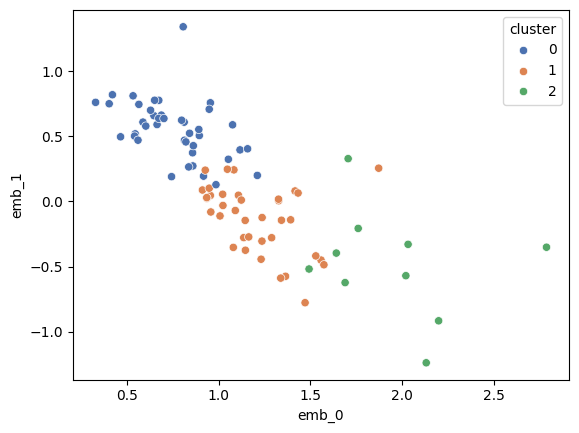

In [6]:
# graph_collection_inner.graphs
import seaborn as sns

sns.scatterplot(data=x, x='emb_0', y='emb_1',hue= 'cluster', palette='deep')

In [24]:
# node_community_mapping

X_df = features.features_df.copy().reset_index().rename(columns={'index': 'og_node_id'})#.drop(columns=['node_id', 'graph_id'])
X_df['subgraph_id'] = x['og_node_id'].map(node_community_mapping)
X_df = X_df.merge(embeddings.embeddings_df.rename(columns={'graph_id':'subgraph_id'}), on='subgraph_id').drop(columns=['og_node_id', 'subgraph_id'])

y = X_df[embeddings.embedding_columns]
X = X_df[features.feature_columns]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4578
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 24
[LightGBM] [Info] Start training from score 1.224149


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

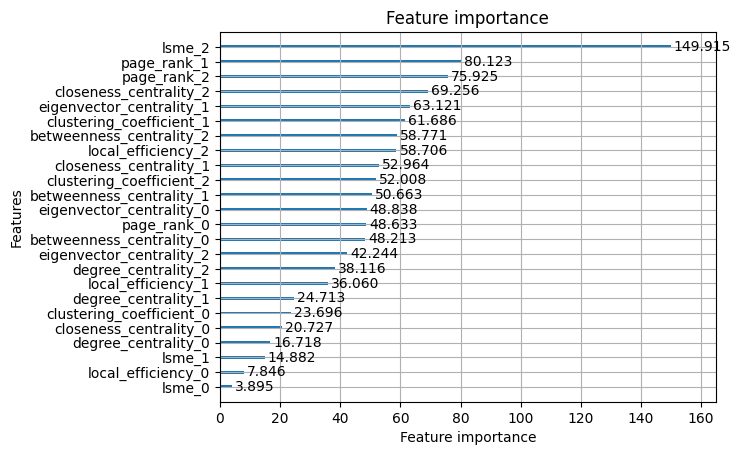

In [37]:
import lightgbm as lgb


# features.features_df

model = lgb.LGBMRegressor(importance_type='gain')
model.fit(X, y['emb_0'])
# model.feature_importances_
lgb.plot_importance(model)